# Practica 1 APC

#### Andrea Gonzalez --> 1603921
#### Ona Sanchez --> 1601181
#### Gerard Lahuerta --> 1601350

## Objectius

Els objectius d'aquesta pràctica són:

* Aplicar models de regressió, ficant l'èmfasi en: 
    1. Analitzar els atributs per seleccionar els més representatius i normalitzar-los.
    2. Avaluar correctament l'error del model 
    3. Visualitzar les dades i el model resultant
    4. Saber aplicar el procès de descens del gradient

* Ésser capaç d'aplicar tècniques de regressió en casos reals

* Validar els resultats en dades reals

* Fomentar la capacitat per presentar resultats tècnics d'aprenentatge computacional de forma adequada davant altres persones


## Apartat (C): Analitzant Dades
En aquest primer apartat s'analitzen els diferents atributs que componen la base de dades i entendre'ls. Així com, es fixa l'atribut objectiu a predir de tots els que hi ha a la base de dades. Les dades analitzades, extretes de Kaggle, son: Human Resources Dataset.

Importació de les dades i llibreries necessàries per a l'anàlisis de les mateixes. 


In [3]:
from sklearn.datasets import make_regression
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
import scipy.stats

# Visualitzarem només 3 decimals per mostra
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Funcio per a llegir dades en format csv
def load_dataset(path):
    dataset = pd.read_csv(path, header=0, delimiter=',')
    return dataset

# Carreguem dataset d'exemple
dataset = load_dataset('HRDataset_v14.csv')
data = dataset.values

x = data[:, :2]
y = data[:, 2]

print("Dimensionalitat de la BBDD:", dataset.shape)
print("Dimensionalitat de les entrades X", x.shape)
print("Dimensionalitat de l'atribut Y", y.shape)

FileNotFoundError: [Errno 2] File HRDataset_v14.csv does not exist: 'HRDataset_v14.csv'

Anàlisi dels ``Nan`` del dataset, en cas d'haver-n'hi es tractaran per la fàcil manipulació de les dades.

In [ ]:
print("Per comptar el nombre de valors no existents:")
print(dataset.isnull().sum())

Fent un recompte del nombre de valors no existents que té cada atributs, observem que existeixen dos atributs amb valors nulls en la base de dades.

Veiem que les variables que contenen valors nulls representen una data i un número identificatiu, pel que es decideix examinar com gestionar els valors nulls. $\newline$

Eliminem l'atribut "DateofTermination" ja que és un atribut perdut (té molts valors no existents) i decidim eliminar-lo directament.

In [ ]:
dataset = dataset.drop(["DateofTermination"], axis=1)

In [ ]:
dataset.head()

Pel que fa a l'atribut ManagerID, substituirem els valors null per una estimació, la moda del ManagerID dels treballadors que tenen el mateix
càrreg. Del conjunt de treballadors s’escull el més probable (la moda) en funció de la posició, per a susbtituïr
el valor null.

In [ ]:
def trobar_moda(dt, col_e, col_a, val):
    lista = {}
    
    types = dt[col_e].unique()
    
    moda = {}
    
    for i in types:
        moda[i] = 0
    
    for i in range(len(dt.axes[0])):
        if dt.iloc[i][col_a] == val and not np.isnan(dataset.iloc[i][col_e]):
            moda[dt.iloc[i][col_e]] += 1
    
    maxi = 0
    for j in moda:
        if moda[j] > maxi:
            maxi = moda[j]
            pos = j

    return pos

In [ ]:
col_e = "ManagerID"
col_a = "Position"
l = []
for i in range(len(dataset.axes[0])):
    if np.isnan(dataset.iloc[i][col_e]):
        val = dataset.iloc[i][col_a]
        l.append(trobar_moda(dataset, col_e, col_a, val))
    else:
        l.append(dataset.iloc[i][col_e])
dataset[col_e] = l

Un cop tractats els valors null, canviem els tipus de variable del dataset a valors numèrics per a poder fer una millor correlació i estudiar de manera més senzilla les dades.

In [ ]:
def ordenar_salary(dt, col):
    lista = {}
    
    types = dt[col].unique()
    
    n_types = {}
    sal = {}
    
    
    for i in types:
        n_types[i] = dt.apply(lambda x: x[col] == i, axis=1).sum()
        sal[i] = 0
    
    cont = [] 
    
    for i in range(len(dt.axes[0])):
        sal[dt.iloc[i][col]]+=dt.iloc[i]["Salary"]/n_types[dt.iloc[i][col]]
    
    val = 0
    for j in range(len(n_types)):
        mini = float("inf")
        for i in sal:
            #print(i)
            if sal[i] < mini:
                mini = sal[i]
                pos = i
        lista[pos] = val
        val += 1
        del sal[pos]
       
    
    return lista

In [ ]:
dt = pd.DataFrame()
dataset_cop = dataset.copy()
col = 0
for i,j in zip(dataset_cop.columns.tolist(), dataset_cop.dtypes):
    i = str(i)
    if str(j) == 'object':
        aux = []  
        dic = ordenar_salary(dataset, dataset_cop.columns.tolist()[col])
        
        for k in range(len(dataset_cop[i])):
            aux.append(dic[dataset_cop[i][k]])
            
        dt[i] = aux
    else:
        dt[i] = dataset_cop[i]
        
    col += 1


Un cop les dades han estat tractades, estudiarem quin és el millor atribut objectiu per a estudiar. $\newline$
Definirem el millor atribut objectiu com aquell que té el màxim de correlacions amb un llindar superior a 0.3 (en valor absolut).

In [ ]:
import seaborn as sns
correlacio = dt.corr()
dic = {}

for i in correlacio:
    dic[i] = -1
    for j in correlacio[i]:
        if abs(j) > 0.3:
            dic[i] += 1
print(dic)

In [ ]:
for i in dic:
    print(dt[i].describe()) #return descripcio de l'atribut del DataFrame
    print("----------------------------------------------------------")

S'observa que els millors atributs són els següents: Termd, DateofTermination, LastPerformanceReview_Date i EmploymentStatus. $\newline$ Tot i així decidim estudiar altres variables amb menys correlacions rellevants a causa de que aquestes abans nombrades son variables discretes amb molt poca dispersió. $\newline$

Respecte a l'output obtingut, hem decidit estudiar l'atribut "Salary" ja que és l'atribut amb més correlacions rellevants sense tenir poca dispersió i és el que ens semblava més interessant.

Estudiem l'atribut objectiu a partir de les variables més significatives (amb un llindar superior a 0.5)

In [ ]:
l = []

s = "Salary"

for i in range(len(correlacio[s])):
    if abs(correlacio[s][i]) > 0.5 and correlacio[s][i] != 1:
        l.append(i)
print(correlacio[s][l])

In [ ]:
names_cor = ["Salary"]
for i in l:
    names_cor.append(dataset_cop.columns.tolist()[i])
print(names_cor)

Una molt bona manera, de determinar les correlacions entre els diversos atributs del dataset és mitjançant la matriu de covariança.

In [ ]:
dataset_cor = dt.copy()

for i in dt:
    if i not in names_cor:
        dataset_cor = dataset_cor.drop(i, axis = 1)

correlacio = dataset_cor.corr() 

plt.figure()

ax = sns.heatmap(correlacio, annot=True, linewidths=.5)

In [ ]:
#També podem utilitzar la funció pairplot per tal de veure els atributs que estan relacionats entre si.

Així doncs, confirmem mitjançant la taula de correlació que els atributs escollits per a estudiar l'objectiu son els més rellevants.

In [ ]:
def standarize(X): #histograma dels atributs
    #print(X)
    mean = X.mean(0)
    std = X.std(0)
    x = X - mean
    x /= std
    return x

for i in dt:
    X = standarize(dt[i].values)
    plt.figure()
    plt.title("Histograma de l'atribut "+str(i))
    plt.xlabel("Attribute Value")
    plt.ylabel("Count")
    hist = plt.hist(X, bins=11, range=[np.min(X), np.max(X)], histtype="bar", rwidth=0.8)
    plt.plot()
    
#També podem estudiar la correlació mitjançant un historgrama

## Apartat (B): Analitzant Dades

En aquest apartat es calcularà l'error quadràtic mitjà només del regressor per a cada un dels atributs de la base de dades, determinant aquell atribut pel qual l'error quadràtic mitjà (entre el valor predit i el real, per a cada mostra) és més baix. 
(MSE). $\newline$

La funció "Mean squeared error" l'utilitzarem per distingir els atributs més importants a l'hora de predir el valor del "Salary".

In [ ]:
import math

def mse(y1, y2):
    # comprovem que y1 i y2 tenen la mateixa mida
    assert(len(y1) == len(y2))
    mse = 0
    for i in range(len(y1)):
        mse += (y1[i] - y2[i])**2
    return mse / len(y1)

Per a la regressió usarem les següents funcions.

In [ ]:
from sklearn.linear_model import LinearRegression

def regression(x, y):
    # Creem un objecte de regressió de sklearn
    regr = LinearRegression()

    # Entrenem el model per a predir y a partir de x
    regr.fit(x, y)
    

    # Retornem el model entrenat
    return regr

Fem una copia estandaritzada del dataset per a comparar les regressions lineals amb i sense les variables estandaritzades.

In [ ]:
def standarize(X):
    mean = X.mean(0)
    std = X.std(0)
    x = X - mean
    x /= std
    return x

dt_std = dt.copy()

for i in dt:
    if i == "Salary":
        dt_std[i] = dt[i]
    else:
        dt_std[i] = standarize(dt[i])

Eliminem les variables amb poca dispersió ja que (en el nostre dataset) aquestes son variables discretes que no poden ser útils per a predir.

In [ ]:
for i in dt:
    values = dt[i].value_counts()
    if len(values) < 6:
        dt = dt.drop(i, axis = 1)
        dt_std = dt_std.drop(i, axis = 1)

Eliminem les variables que serveixen d'identificació per al treballador (Employee_Name i DOB)

In [4]:
dt = dt.drop("Employee_Name", axis = 1)
dt_std = dt_std.drop("Employee_Name", axis = 1)
dt = dt.drop("DOB", axis = 1)
dt_std = dt_std.drop("DOB", axis = 1)

NameError: name 'dt' is not defined

Fem la recta de regressió per la variable "Salary" en funció de les variables que ens queden en el dataset.

In [ ]:
from sklearn.metrics import r2_score

y = dt["Salary"]
for i in dt:
    if i != "Salary":
        x = np.array(dt[i])
        X = x.reshape(x.shape[0], 1) 
        regr = regression(X, y) 
        predicted = regr.predict(X)

        # Mostrem la predicció del model entrenat en color vermell a la Figura anterior 1
        plt.figure()
        plt.title(i)
        ax = plt.scatter(x, y)
        plt.plot(X, predicted, 'r')

        # Mostrem l'error (MSE i R2)
        MSE = mse(y, predicted)
        r2 = r2_score(y, predicted)
        
        print(i)
        print("Mean squeared error: ", MSE)
        print("R2 score: ", r2)
        print("----------------------------------------------------")

In [ ]:
y = dt_std["Salary"]
for i in dt_std:
    if i != "Salary":
        x = np.array(dt_std[i])
        X = x.reshape(x.shape[0], 1) 
        regr = regression(X, y) 
        predicted = regr.predict(X)

        # Mostrem la predicció del model entrenat en color vermell a la Figura anterior 1
        plt.figure()
        plt.title(i)
        ax = plt.scatter(x, y)
        plt.plot(X, predicted, 'r')

        # Mostrem l'error (MSE i R2)
        MSE = mse(y, predicted)
        r2 = r2_score(y, predicted)
        
        print(i)
        print("Mean squeared error: ", MSE)
        print("R2 score: ", r2)
        print("----------------------------------------------------")

S'observa que la millor dada és la de Postion amb MSE = 100190785.86004272 i R2 = 0.8411741038500034.

També recalcar que la regressió amb les dades normalitzades s'obté un MSE i un R2 bastant més petit i gran respectivament, de manera que els valors obtinguts son més facils de tractar. Farem totes les regressions seguents amb el dataset estandaritzat.

Per a assegurar que el model s'ajusta be a dades creem un conjunt de validacio i un de test. $\newline$
El generarem separant les dades en un 80% d'entrenament i un 20% de validació.

In [ ]:
def split_data(x, y, train_ratio=0.8):
    indices = np.arange(x.shape[0])
    np.random.shuffle(indices)
    n_train = int(np.floor(x.shape[0]*train_ratio))
    indices_train = indices[:n_train]
    indices_val = indices[n_train:] 
    x_train = x[indices_train, :]
    y_train = y[indices_train]
    x_val = x[indices_val, :]
    y_val = y[indices_val]
    return x_train, y_train, x_val, y_val

y = np.array(dt_std["Salary"])
for j in dt_std:
    if j != "Salary":
        x = np.array(dt_std[j])
        x = x.reshape(x.shape[0], 1) 

        x_train, y_train, x_val, y_val = split_data(x, y)

        x_t = x_train # seleccionem atribut i en conjunt de train
        x_v = x_val # seleccionem atribut i en conjunt de val.
        x_t = np.reshape(x_t,(x_t.shape[0],1))
        x_v = np.reshape(x_v,(x_v.shape[0],1))

        regr = regression(x_t, y_train)    
        error = mse(y_val, regr.predict(x_v)) # calculem error
        r2 = r2_score(y_val, regr.predict(x_v))

        print("Error en atribut %s: %f" %(j, error))
        print("R2 score en atribut %s: %f" %(j, r2))
        print("----------------------------------------------------------------")

S'han corroborat els resultats obtinguts anteriorment sense el test de validació i els raonats a l'apartat C, els millors atributs per a fer la regressió lineal son: DeptID, ManagerID, Position i SpecialProjectsCount ja que son els que niminitcen i maximitcen el MSE i el R2 score respectivament.

Procedim a estudiar quin es el millor regressor possible per a predir el "Salary" mitjançant les dades i el resultats obtinguts en el anàlisis. Fem la recta de predicció del "Salary" amb els 4 atributs més rellevants mencionats abans i estudiant la qualitat de la seva predicció.

In [ ]:
l = []
s = "Salary"

correlacio = dt_std.corr()

for i in range(len(correlacio[s])):
    if abs(correlacio[s][i]) > 0.5 and correlacio[s][i] != 1:
        l.append(i)
print(correlacio[s][l])

In [ ]:
names_cor = []
for i in l:
    names_cor.append(dt_std.columns.tolist()[i])
print(names_cor)

In [ ]:
def split_data(x, y, train_ratio=0.8):
    indices = np.arange(x.shape[0])
    np.random.shuffle(indices)
    n_train = int(np.floor(x.shape[0]*train_ratio))
    indices_train = indices[:n_train]
    indices_val = indices[n_train:] 
    x_train = x[indices_train, :]
    y_train = y[indices_train]
    x_val = x[indices_val, :]
    y_val = y[indices_val]
    return x_train, y_train, x_val, y_val


dt_std_cp = dt_std.copy()

y = np.array(dt_std['Salary'])
for i in dt_std_cp:
    if i not in names_cor:
        dt_std_cp = dt_std_cp.drop(i, axis = 1)

x = dt_std_cp.to_numpy()

x_train, y_train, x_val, y_val = split_data(x, y)

x_t = x_train # seleccionem atribut i en conjunt de train
x_v = x_val # seleccionem atribut i en conjunt de val.
# x_t = np.reshape(x_t,(x_t.shape[0],20))
# x_v = np.reshape(x_v,(x_v.shape[0],20))

regr = regression(x_t, y_train)    
error = mse(y_val, regr.predict(x_v)) # calculem error
r2 = r2_score(y_val, regr.predict(x_v))

print("Mean squeared error: ", error)
print("R2 score: ", r2)

Concluïm que si utilitzem els atributs més rellevants trobats durant l'analisis ( DateofHire, Departmen, Position, ManagerName i SpecialProjectsCount), els valors de MSE i R2 score "s'estabilitcen", fent que obtinguin valors suficientment bons.

Decidim fer una PCA dels atributs per tal de veure com es distribueixen els atributs en R3, agafem de la llista d'atributs més rellevants dos a dos i tres a tres per a fer la PCA i comparem les PCA obtingudes.

In [ ]:
# Scatter
%matplotlib notebook
# importamos las librerias necesarias
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from ipywidgets import interact

M = dt_std_cp.to_numpy()
M = M.transpose()

l = [i for i in range(np.shape(M)[0])]
n = names_cor

z = np.array(dt_std['Salary'])


for i in l:
    for j in l:
        if j > i:
            print("Salary: ",n[i],"--", n[j])
            # Creamos la figura
            fig = plt.figure()
            # Creamos el plano 3D
            ax = fig.gca(projection='3d')

            # Definimos los datos de prueba
            x = M[i]
            y = M[j]

            # Agregamos los puntos en el plano 3D
            ax.scatter(x, y, z, c='g', marker='o')

            # Mostramos el gráfico
            plt.show()

In [ ]:
# Scatter
%matplotlib notebook
# importamos las librerias necesarias
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from ipywidgets import interact

M = dt_std_cp.to_numpy()
M = M.transpose()

l = [[0,1,2],[1,2,3],[2,3,4],[3,4,0], [4,0,1]]
n = names_cor

a = np.array(dt['Salary'])
a = a/max(a)
v = [i for i in range(len(a))]

for i in l:
    print("Salary: ",n[i[0]],"--", n[i[1]], "--", n[i[2]])
    # Creamos la figura
    fig = plt.figure()
    # Creamos el plano 3D
    ax = fig.gca(projection='3d')

    # Definimos los datos de prueba
    x = M[i[0]]
    y = M[i[1]]
    z = M[i[2]]

    # Agregamos los puntos en el plano 3D
    img = ax.scatter(x, y, z, c = np.take(a, v), marker='o')
    
#     surface = ax.plot_surface(x,y,z, cmap = "summer")
    fig.colorbar(img)

    # Mostramos el gráfico
    plt.show()

In [ ]:
pip install plotly

In [ ]:
import plotly.express as px
from sklearn.decomposition import PCA


features = ['Position', 'DateofHire', 'Department', 'ManagerName', 'SpecialProjectsCount']

pca = PCA()
components = pca.fit_transform(dt_std[features])
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    components,
    labels=labels,
    dimensions=range(4),
    color=dt_std["Salary"]
)
fig.update_traces(diagonal_visible=False)
fig.show()

Observem que no hi existeix cap distinció aparent entre les dades obtingudes i el valor del "Salary" només amb 2 i tres atributs. Decidim calcular el MSE i el R2 score per a cada una de les combinacions abans mostrades, mostrem també els valors dels coeficients de cada una de les regressions lineals i les comparem amb les que hem obtingut utilitzant els 5 atributs. $\newline$ Repetim cada predicció 1000 vegades (amb tests diferents) per tal d'obtenir uns valors "estables".

In [ ]:
from itertools import combinations

def combination(A, n_conj):
    temp = combinations(A, n_conj)
    aux = []
    for i in temp:
        aux.append(list(i))
    return aux

In [ ]:
y = np.log(np.array(dt_std['Salary']))
rep = 1000

error_min = np.inf
pos_e = 0
r2_max = 0
pos_r = 0

l = combination(names_cor,2) + combination(names_cor,3) + combination(names_cor,4) + [names_cor]

for j in l:
    dt_std_cp = dt_std.copy()

    for i in dt_std_cp:
        if i not in j:
            dt_std_cp = dt_std_cp.drop(i, axis = 1)

    x = dt_std_cp.to_numpy()
    error = 0
    r2 = 0
    inter = 0
    coef = [0 for k in range(len(j))]

    for k in range(rep):
        x_train, y_train, x_val, y_val = split_data(x, y)

        x_t = x_train # seleccionem atribut i en conjunt de train
        x_v = x_val # seleccionem atribut i en conjunt de val.
        # x_t = np.reshape(x_t,(x_t.shape[0],20))
        # x_v = np.reshape(x_v,(x_v.shape[0],20))

        regr = regression(x_t, y_train)    
        error += mse(np.exp(y_val), np.exp(regr.predict(x_v))) # calculem error
        r2 += r2_score(y_val, regr.predict(x_v))
        coef += regr.coef_
        inter += regr.intercept_
        
        

    print(j)
    print("Mean squeared error: ", error/rep)
    print("R2 score: ", r2/rep)
    print("Coef: ", coef/rep)
    print("Intercept: ", inter/rep)
    print("--------------------------------------")
    
    if r2/rep > r2_max:
        r2_max = r2/rep
        pos_r = j
    if error/rep < error_min:
        error_min = error/rep
        pos_e = j

print("MILLOR R2 SCORE A: ", pos_r, r2_max)  
print("MILLOR ERROR A: ", pos_e, error_min)        


Concluïm que de totes les combinacions possibles amb els cinc atributs, la millor és amb 'Position', 'DateofHire', 'ManagerName' ja que és la que més augmenta el R2 score i redueix l'error (MSE) casi tant com la combinació de 'Position', 'DateofHire', 'ManagerName', 'SpecialProjectsCount' (que és la que més ho redueix), per una diferencia de milesimes. $\newline$
Recomanem que en cas de fer una regressió multilineal per a predir el "Salary" és faci mitjançant els atributs 'Position', 'DateofHire', 'ManagerName'.

Procedim a repetir l'estudi amb els mètode Lasso i BayessianRidge i ampliar l'analisis obtingut per al millor regerssor que hi trobem mitjançant la eliminació d'Outliners i aplicant un interval de confiança

In [ ]:
from sklearn import linear_model

def lasso(x, y, a = 0.1):

    # Creem un objecte de regressió de sklearn
    regr = linear_model.Lasso(alpha=a)

    # Entrenem el model per a predir y a partir de x
    regr.fit(x, y)

    # Retornem el model entrenat
    return regr

y = np.array(dt_std['Salary'])
rep = 1000

error_min = np.inf
pos_e = 0
r2_max = 0
pos_r = 0

l = combination(names_cor,2) + combination(names_cor,3) + combination(names_cor,4) + [names_cor]

for j in l:
    dt_std_cp = dt_std.copy()

    for i in dt_std_cp:
        if i not in j:
            dt_std_cp = dt_std_cp.drop(i, axis = 1)

    x = dt_std_cp.to_numpy()
    error = 0
    r2 = 0
    inter = 0
    coef = [0 for k in range(len(j))]

    for k in range(rep):
        x_train, y_train, x_val, y_val = split_data(x, y)

        x_t = x_train # seleccionem atribut i en conjunt de train
        x_v = x_val # seleccionem atribut i en conjunt de val.
        # x_t = np.reshape(x_t,(x_t.shape[0],20))
        # x_v = np.reshape(x_v,(x_v.shape[0],20))

        regr = lasso(x_t, y_train)    
        error += mse(y_val, regr.predict(x_v)) # calculem error
        r2 += r2_score(y_val, regr.predict(x_v))
        coef += regr.coef_
        inter += regr.intercept_
        
        

    print(j)
    print("Mean squeared error: ", error/rep)
    print("R2 score: ", r2/rep)
    print("Coef: ", coef/rep)
    print("Intercept: ", inter/rep)
    print("--------------------------------------")
    
    if r2/rep > r2_max:
        r2_max = r2/rep
        pos_r = j
    if error/rep < error_min:
        error_min = error/rep
        pos_e = j

print("MILLOR R2 SCORE A: ", pos_r, r2_max)  
print("MILLOR ERROR A: ", pos_e, error_min)  

In [ ]:
from sklearn.linear_model import BayesianRidge

def Bayes(x, y, t = 1e-6):

    # Creem un objecte de regressió de sklearn
    regr = BayesianRidge(tol= t)

    # Entrenem el model per a predir y a partir de x
    regr.fit(x, y)

    # Retornem el model entrenat
    return regr

y = np.array(dt_std['Salary'])
rep = 1000

error_min = np.inf
pos_e = 0
r2_max = 0
pos_r = 0

l = combination(names_cor,2) + combination(names_cor,3) + combination(names_cor,4) + [names_cor]

for j in l:
    dt_std_cp = dt_std.copy()

    for i in dt_std_cp:
        if i not in j:
            dt_std_cp = dt_std_cp.drop(i, axis = 1)

    x = dt_std_cp.to_numpy()
    error = 0
    r2 = 0
    inter = 0
    coef = [0 for k in range(len(j))]

    for k in range(rep):
        x_train, y_train, x_val, y_val = split_data(x, y)

        x_t = x_train # seleccionem atribut i en conjunt de train
        x_v = x_val # seleccionem atribut i en conjunt de val.
        # x_t = np.reshape(x_t,(x_t.shape[0],20))
        # x_v = np.reshape(x_v,(x_v.shape[0],20))

        regr = Bayes(x_t, y_train)    
        error += mse(y_val, regr.predict(x_v)) # calculem error
        r2 += r2_score(y_val, regr.predict(x_v))
        coef += regr.coef_
        inter += regr.intercept_
        
        

    print(j)
    print("Mean squeared error: ", error/rep)
    print("R2 score: ", r2/rep)
    print("Coef: ", coef/rep)
    print("Intercept: ", inter/rep)
    print("--------------------------------------")
    
    if r2/rep > r2_max:
        r2_max = r2/rep
        pos_r = j
    if error/rep < error_min:
        error_min = error/rep
        pos_e = j

print("MILLOR R2 SCORE A: ", pos_r, r2_max)  
print("MILLOR ERROR A: ", pos_e, error_min)  

MILLOR R2 SCORE A:  ['Position', 'DateofHire', 'Department'] 0.8281589261980032 $\newline$
MILLOR ERROR A:  ['Position', 'DateofHire'] 103817843.67496361

In [ ]:
dt_copia_seguridad = dt_std.copy()

In [ ]:
y = np.log(dt_std["Salary"])
for i in dt_std:
    if i != "Salary":
        name = i
        x = np.array(dt_std[i])
        X = x.reshape(x.shape[0], 1) 
        #regr = regression(X, y) 
        #regr = lasso(X, y, a = 0.001) 
        regr = Bayes(X, y, t = 1e-12) 
        predicted = regr.predict(X)
        
        # Mostrem la predicció del model entrenat en color vermell a la Figura anterior 1
        fig, ax = plt.subplots(figsize=(6, 3.84))
        
        aux = []
        for i,j in zip(X,predicted):
            aux.append(np.array([i[0],j]))
        aux = np.array(aux)
        aux = aux[aux[:,0].argsort()]
        
        xi = []
        yi = []

        for i in aux:
            xi.append(np.array([i[0]]))
            
        pred = regr.predict(xi)
        
        xi = []
        for i in aux:
            xi.append(i[0])
            yi.append(i[1])
        
        stdev = np.sqrt(sum((pred - y)**2) / (len(y) - 2))
        min_pred = pred - 0.675*stdev
        max_pred = pred + 0.675*stdev
        
        ax.scatter(X, np.exp(y), marker='o', color = "gray")
        ax.plot(xi, np.exp(pred), linestyle='-', label="OLS")
        
        # Mostrem l'error (MSE i R2)
        MSE = mse(y, predicted)
        r2 = r2_score(y, predicted)
        print(name)
        print("Mean squeared error: ", MSE)
        print("R2 score: ", r2)
        print("----------------------------------------------------")

In [1]:
def split_data(x, y, train_ratio=0.8):
    indices = np.arange(x.shape[0])
    np.random.shuffle(indices)
    n_train = int(np.floor(x.shape[0]*train_ratio))
    indices_train = indices[:n_train]
    indices_val = indices[n_train:] 
    x_train = x[indices_train, :]
    y_train = y[indices_train]
    x_val = x[indices_val, :]
    y_val = y[indices_val]
    return x_train, y_train, x_val, y_val


y = np.log(dt_std["Salary"])

for i in dt_std:
    if i != "Salary":
        x = np.array(dt_std[i])
        X = x.reshape(x.shape[0], 1) 
        
        x_t, y_t, x_v, y_v = split_data(X, y)
        
        #regr = regression(X, y) 
        regr = lasso(x_t, y_t, a = 0.001) 
        #regr = Bayes(X, y, t = 1e-12) 
        predicted = regr.predict(x_t)
        
        # Mostrem la predicció del model entrenat en color vermell a la Figura anterior 1
        fig, ax = plt.subplots(figsize=(6, 3.84))
        
        aux = []
        for i,j in zip(x_t,predicted):
            aux.append(np.array([i[0],j]))
        aux = np.array(aux)
        aux = aux[aux[:,0].argsort()]
        
        xi = []
        yi = []

        for i in aux:
            xi.append(np.array([i[0]]))
            
        pred = regr.predict(xi)
        
        xi = []
        for i in aux:
            xi.append(i[0])
            yi.append(i[1])
        
        stdev = np.sqrt(sum((pred - y_t)**2) / (len(y_t) - 2))
        min_pred = pred - 0.675*stdev
        max_pred = pred + 0.675*stdev
        
        ax.scatter(X, np.exp(y), marker='o', color = "gray")
        ax.plot(xi, np.exp(pred), linestyle='-', label="OLS")
        ax.plot(xi, np.exp(min_pred), linestyle='--', color='red', label="95% CI")
        ax.plot(xi, np.exp(max_pred), linestyle='--', color='red')
        ax.fill_between(xi, np.exp(min_pred), np.exp(max_pred), alpha=0.1)
        
        # Mostrem l'error (MSE i R2)
        MSE = mse(list(y_v), list(regr.predict(x_v)))
        r2 = r2_score(y_v, regr.predict(x_v))
        
        print("Mean squeared error: ", MSE)
        print("R2 score: ", r2)
        print("----------------------------------------------------")

NameError: name 'np' is not defined

In [43]:
print(len(dt_copia_seguridad["Salary"]))
dt_copia_seguridad = dt_copia_seguridad.drop(dt_copia_seguridad["Salary"].idxmax(), axis = 0)
dt_copia_seguridad.isnull().sum()
dt_copia_seguridad = dt_copia_seguridad.drop(dt_copia_seguridad["Salary"].idxmax(), axis = 0)
print(len(dt_copia_seguridad["Salary"]))

311
309


<IPython.core.display.Javascript object>


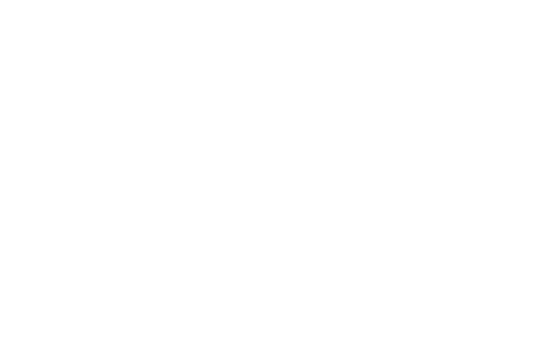

Mean squeared error:  0.07357143931888692
R2 score:  0.005529519330342181
----------------------------------------------------


<IPython.core.display.Javascript object>


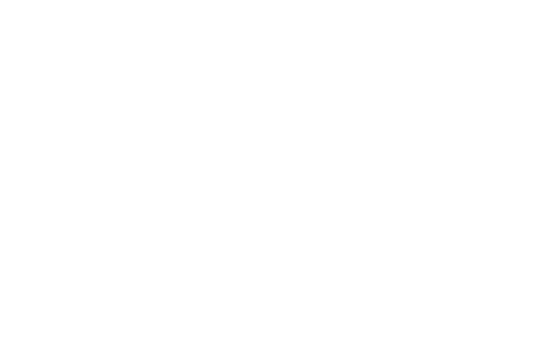

Mean squeared error:  0.05637540300434675
R2 score:  0.3177954504906393
----------------------------------------------------


<IPython.core.display.Javascript object>


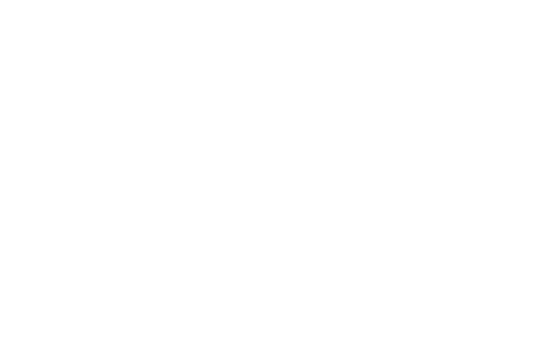

Mean squeared error:  0.06027731192867531
R2 score:  0.0072910268076069595
----------------------------------------------------


<IPython.core.display.Javascript object>


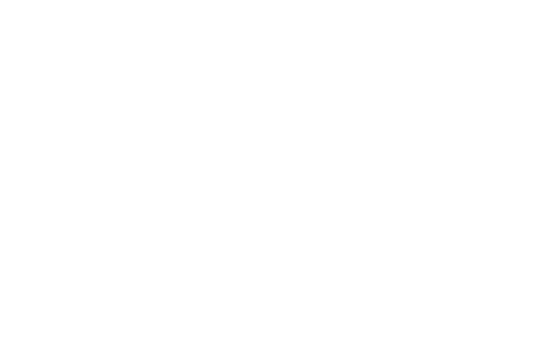

Mean squeared error:  0.011366961638398435
R2 score:  0.7719285931395083
----------------------------------------------------


<IPython.core.display.Javascript object>


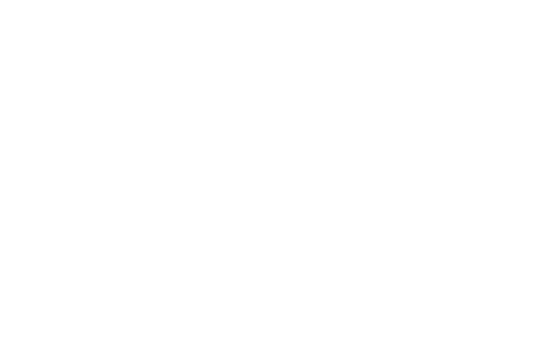

Mean squeared error:  0.06376945059954846
R2 score:  -0.009480100942542036
----------------------------------------------------


<IPython.core.display.Javascript object>


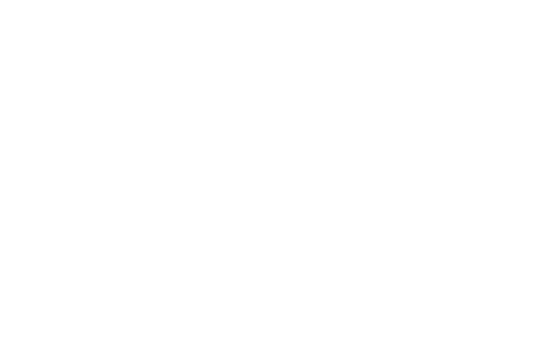

Mean squeared error:  0.07194637481691502
R2 score:  -0.01920837200881409
----------------------------------------------------


<IPython.core.display.Javascript object>


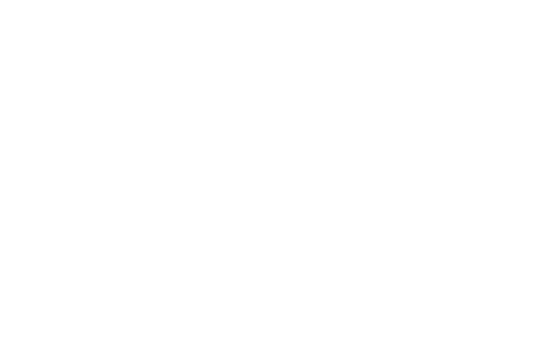

Mean squeared error:  0.08991582403809534
R2 score:  0.005529794508834951
----------------------------------------------------


<IPython.core.display.Javascript object>


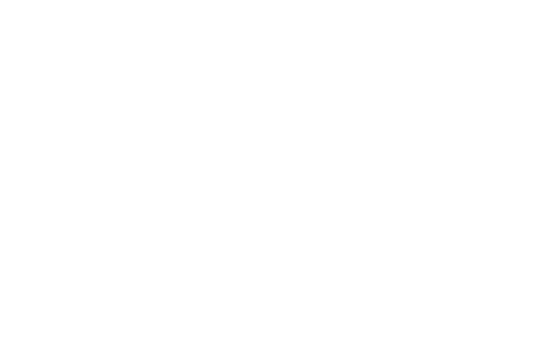

Mean squeared error:  0.059125556457423484
R2 score:  0.2556605763627151
----------------------------------------------------


<IPython.core.display.Javascript object>


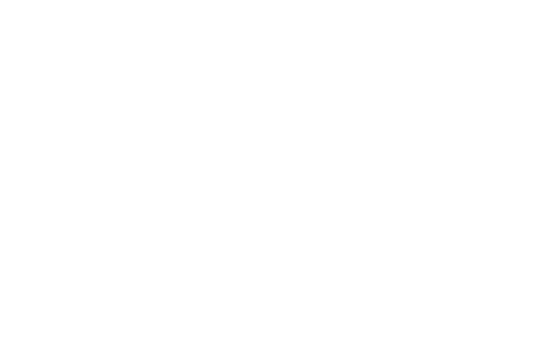

Mean squeared error:  0.05189419133458889
R2 score:  0.04285826938788018
----------------------------------------------------


<IPython.core.display.Javascript object>


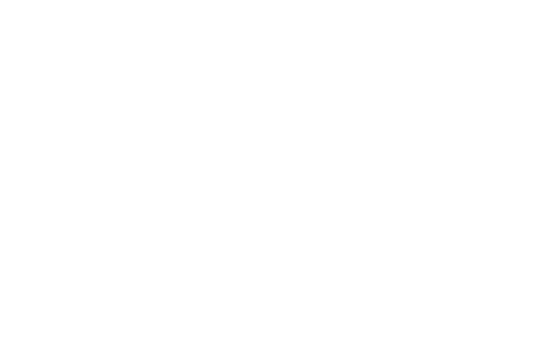

Mean squeared error:  0.05175739877901803
R2 score:  0.29999512086168123
----------------------------------------------------


<IPython.core.display.Javascript object>


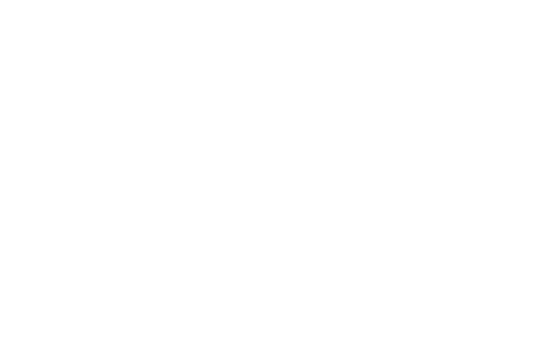

Mean squeared error:  0.035653614662332155
R2 score:  0.5610393322004821
----------------------------------------------------


<IPython.core.display.Javascript object>


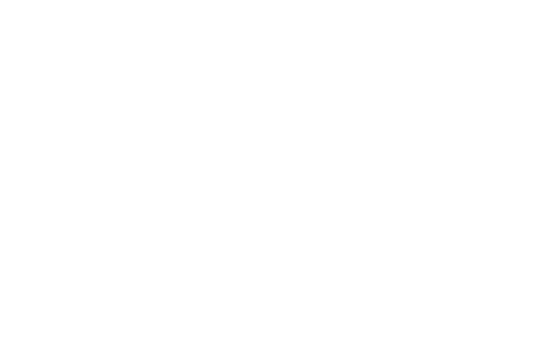

Mean squeared error:  0.0678134915771844
R2 score:  0.15170821998230877
----------------------------------------------------


<IPython.core.display.Javascript object>


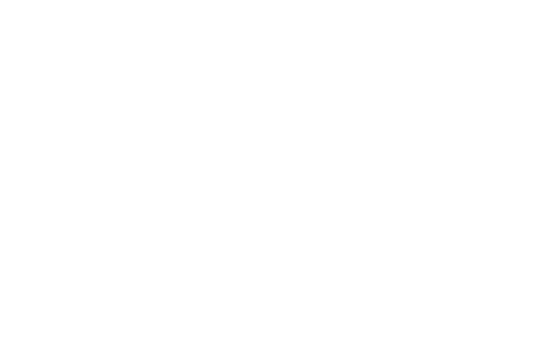

Mean squeared error:  0.05199034062694654
R2 score:  0.1350563976850413
----------------------------------------------------


<IPython.core.display.Javascript object>


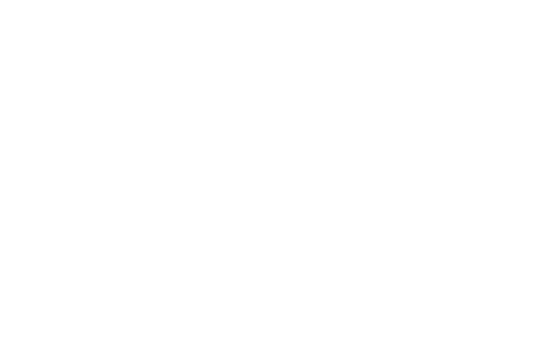

Mean squeared error:  0.09228005878301009
R2 score:  -0.053481262962536746
----------------------------------------------------


<IPython.core.display.Javascript object>


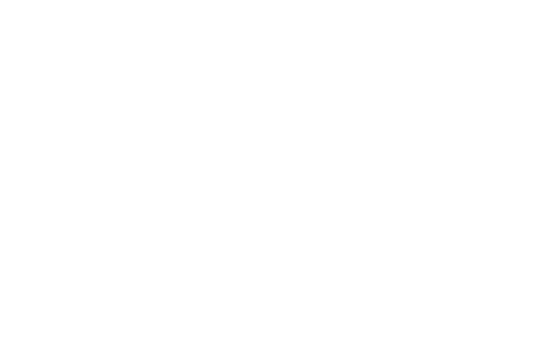

Mean squeared error:  0.04341794279888603
R2 score:  0.3162116612604039
----------------------------------------------------


<IPython.core.display.Javascript object>


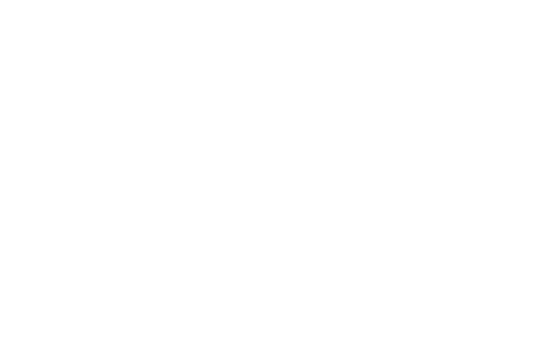

Mean squeared error:  0.049136098159279336
R2 score:  0.3563146582700417
----------------------------------------------------


<IPython.core.display.Javascript object>


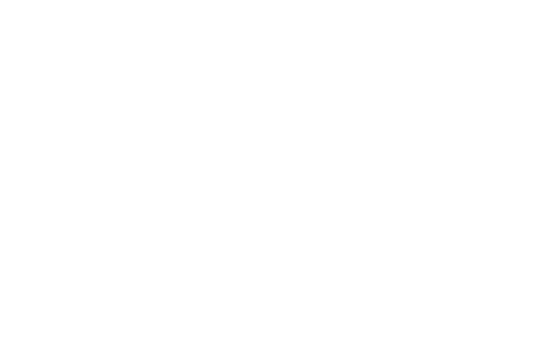

Mean squeared error:  0.09040157765407703
R2 score:  -0.027418981335942227
----------------------------------------------------


<IPython.core.display.Javascript object>


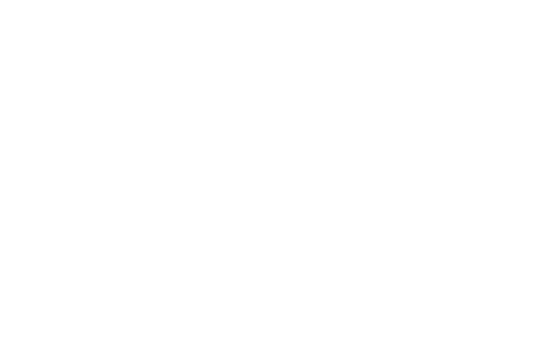

Mean squeared error:  0.09510926523639486
R2 score:  -0.10582801826415356
----------------------------------------------------


<IPython.core.display.Javascript object>


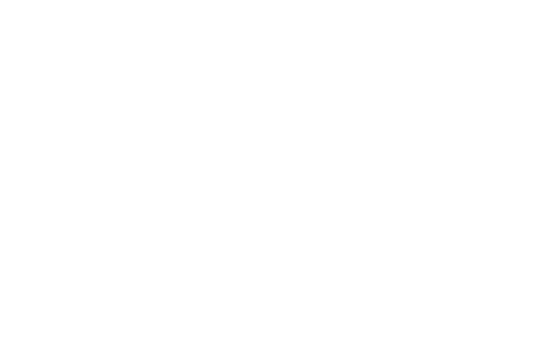

<IPython.core.display.Javascript object>


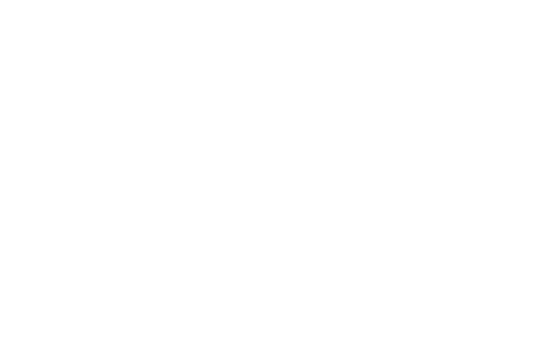

<IPython.core.display.Javascript object>


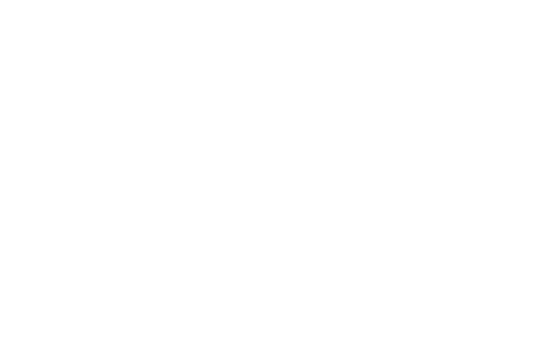

<IPython.core.display.Javascript object>


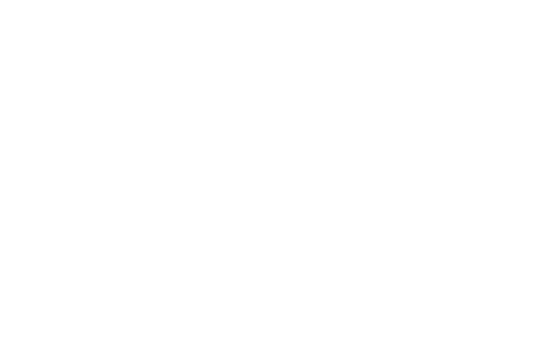

<IPython.core.display.Javascript object>


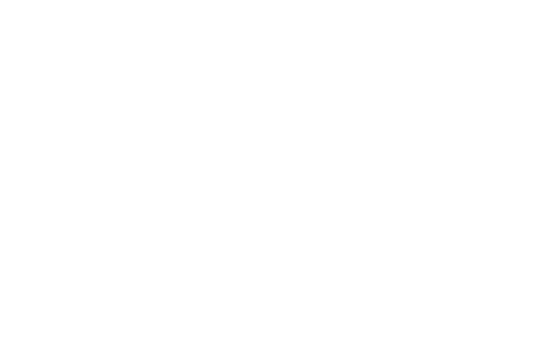

<IPython.core.display.Javascript object>


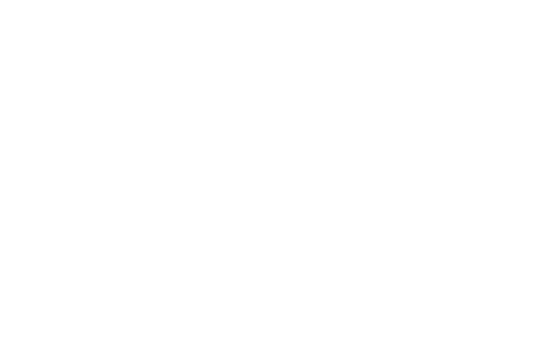

<IPython.core.display.Javascript object>


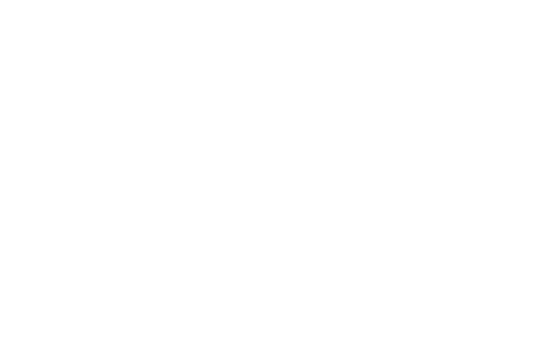

<IPython.core.display.Javascript object>


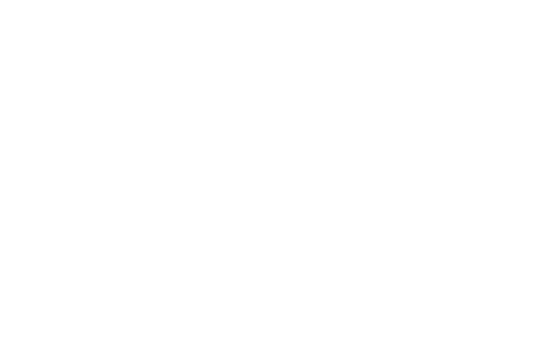

<IPython.core.display.Javascript object>


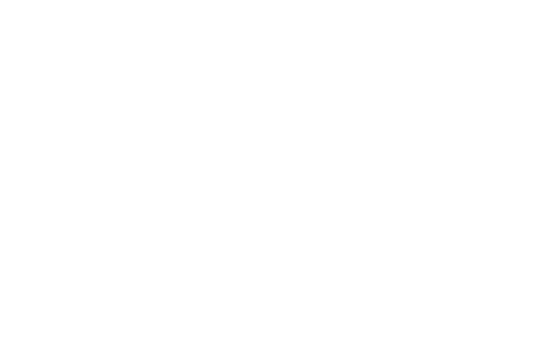

<IPython.core.display.Javascript object>


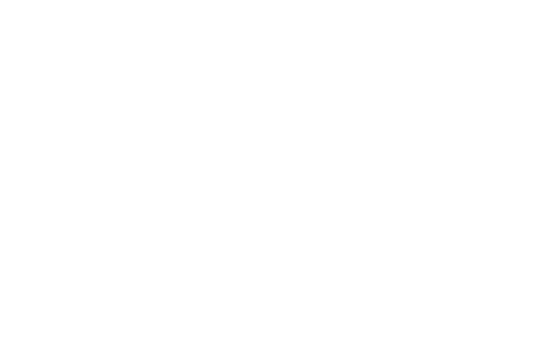

<IPython.core.display.Javascript object>


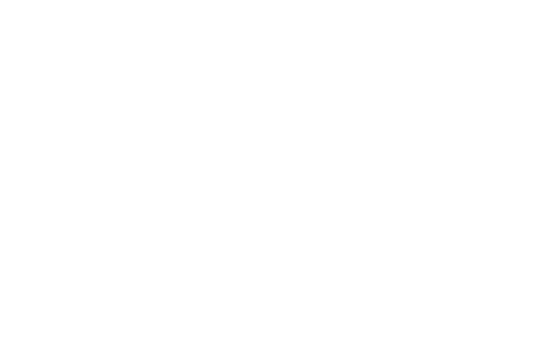

<IPython.core.display.Javascript object>


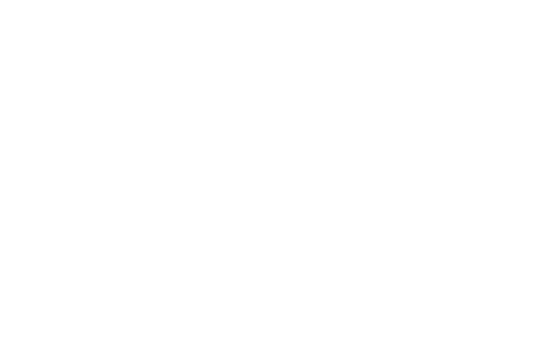

<IPython.core.display.Javascript object>


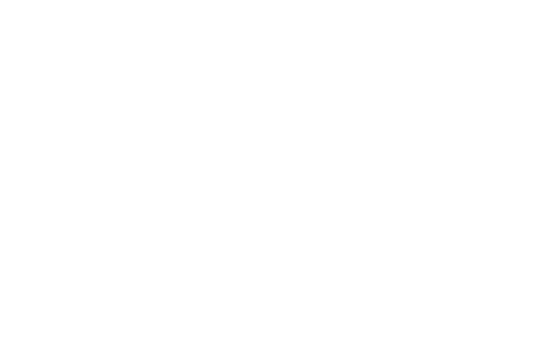

<IPython.core.display.Javascript object>


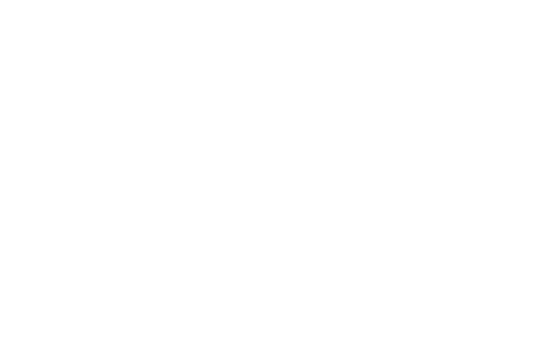

<IPython.core.display.Javascript object>


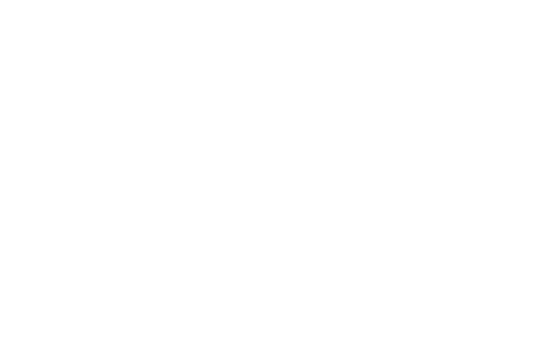

<IPython.core.display.Javascript object>


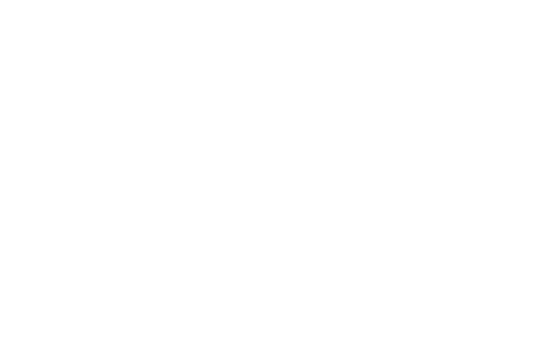

<IPython.core.display.Javascript object>


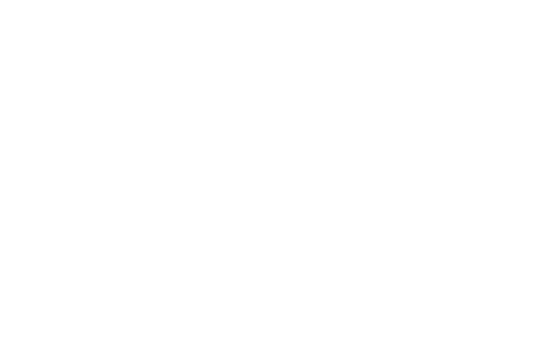

<IPython.core.display.Javascript object>


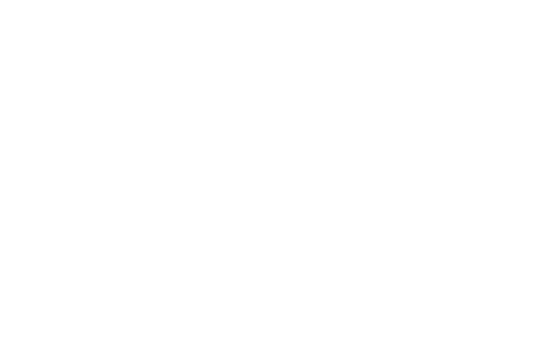

In [44]:
def split_data(x, y, train_ratio=0.8, maxi = []):
    indices = np.arange(x.shape[0])
    if len(maxi) > 0:
        for i in maxi:
            indices = np.delete(indices, i)
            
    np.random.shuffle(indices)
    n_train = int(np.floor(indices.shape[0]*train_ratio))
    indices_train = indices[:n_train]
    indices_val = indices[n_train:] 
    x_train = x[indices_train, :]
    y_train = y[indices_train]
    x_val = x[indices_val, :]
    y_val = y[indices_val]
    return x_train, y_train, x_val, y_val


y = np.log(dt_std["Salary"])

for i in dt_std:
    if i != "Salary":
        x = np.array(dt_std[i])
        X = x.reshape(x.shape[0], 1) 
        
        x_t, y_t, x_v, y_v = split_data(X, y, maxi = [150, 307])
        
        #regr = regression(X, y) 
        regr = lasso(x_t, y_t, a = 0.001) 
        #regr = Bayes(X, y, t = 1e-12) 
        predicted = regr.predict(x_t)
        
        # Mostrem la predicció del model entrenat en color vermell a la Figura anterior 1
        fig, ax = plt.subplots(figsize=(6, 3.84))
        
        aux = []
        for i,j in zip(x_t,predicted):
            aux.append(np.array([i[0],j]))
        aux = np.array(aux)
        aux = aux[aux[:,0].argsort()]
        
        xi = []
        yi = []

        for i in aux:
            xi.append(np.array([i[0]]))
            
        pred = regr.predict(xi)
        
        
        aux = []
        for i,j in zip(x_t,y_t):
            aux.append(np.array([i[0],j]))
        aux = np.array(aux)
        aux = aux[aux[:,0].argsort()]
        
        xi = []
        for i in aux:
            xi.append(i[0])
            yi.append(i[1])
        
        stdev = np.sqrt(sum((pred - yi)**2) / (len(yi) - 2))
        min_pred = pred - 1.96*stdev
        max_pred = pred + 1.96*stdev
        
        ax.scatter(X, np.exp(y), marker='o', color = "gray")
        ax.scatter(X[150], np.exp(y[150]), marker='o', color = "orange")
        ax.scatter(X[308], np.exp(y[308]), marker='o', color = "orange")
        ax.plot(xi, np.exp(pred), linestyle='-', label="OLS")
        ax.plot(xi, np.exp(min_pred), linestyle='--', color='red', label="95% CI")
        ax.plot(xi, np.exp(max_pred), linestyle='--', color='red')
        ax.fill_between(xi, np.exp(min_pred), np.exp(max_pred), alpha=0.1)
        
        # Mostrem l'error (MSE i R2)
        MSE = mse(list(y_v), list(regr.predict(x_v)))
        r2 = r2_score(y_v, regr.predict(x_v))
        
        print("Mean squeared error: ", MSE)
        print("R2 score: ", r2)
        print("----------------------------------------------------")

In [45]:
dt_std["Salary"][308]
np.where(dt_std["Salary"] >= dt_std["Salary"][308])

(array([150, 308], dtype=int64),)

In [46]:
import plotly.express as px
from sklearn.decomposition import PCA


features = ['Position', 'DateofHire', 'Department', 'ManagerName', 'SpecialProjectsCount']

pca = PCA()
components = pca.fit_transform(dt_std[features])
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    components,
    labels=labels,
    dimensions=range(4),
    color=dt_std["Salary"]
)
fig.update_traces(diagonal_visible=False)
fig.show()

# Apartat (A): El descens del gradient  

Implementació del desces del gradient. 

$$J(w) = \frac{1}{2m} \left[ \sum^m_{i=1}(f(x^{i}; w) - y^{i})^2 + \lambda\sum_{j=1}^{n}(w_{j}^2) \right]$$

Fixeu-vos que $J$ retorna el `mse`. Per a trobar $w_j$, repetir fins convergència:
$$w_0 = w_0 - \alpha \frac{1}{m} \sum_{i=1}^{m}(f(x^{i}; w)-y^{i}) \cdot 1$$
$$w_j = w_j - \alpha \left[\frac{1}{m} \sum_{i=1}^{m}(f(x^{i}; w)-y^{i}) \cdot x_{j}^{i} - \frac{\lambda}{m}w_{j} \right]$$


ó:

$$w_{j} := w_{j} \left(1-\alpha \frac{\lambda}{m} \right) - \alpha\frac{\lambda}{m} \sum_{i=1}^{m}(f(x^{i}; w)-y^{i}) \cdot x_{j}^{i}$$


* Definir la funció de cost i del gradient

* Estudiar com l'ús de regularitzadors afecta el resultat: overfitting, underfitting, etc. 

* Visualització de les dades a analitzar i explicació pas a pas del procediment   

* Visualització del procés de descens de gradient 

* Modificar el learning rate i el nombre d'iteracions 


In [47]:
class Regressor(object):
    def __init__(self, x, y, w = [], alpha = 0.1, lam = 0.1, max_iter = 1000, epsilon = 1e-6):
        # Inicialitzem w0 i w1 (per ser ampliat amb altres w's)
        assert len(x) == len(y)
        
        if len(w) == 0:
            try:
                w = [0 for i in range(len(x[0])+1)]
            except:
                w = [0,0]
        
        self.w = w
        self.alpha = alpha
        self.lam = lam
        
        self.train(max_iter, epsilon, x, y)

        
    def predict(self, x):
        # implementar aqui la funció de prediccio
        res = self.w[0]
        try:
            for i,j in zip(x,self.w[1:]):
                res += i*j
        except:
            res +=x*self.w[1]
            
        return res
    
    def __update(self, hy, y, x):
        # actualitzar aqui els pesos donada la prediccio (hy) i la y real.
        for j in range(len(self.w)-1):
            sumatori = 0
            try:
                for i in range(len(hy)):
                    sumatori += (hy[i]-y[i])*x[i]
                self.w[j+1] = self.w[j+1]*(1-self.alpha*self.lam*(1/len(x))) - self.alpha*self.lam*(1/len(x)) * sumatori
            except:
                #print(hy,y,x)
                sumatori = (hy-y)*x
                self.w[j+1] = self.w[j+1]*(1-self.alpha*self.lam)-self.alpha*self.lam*sumatori
                #print(self.w[j], 1-self.alpha*self.lam, self.alpha*self.lam*sumatori)
                self.w[0] -= self.alpha*(hy-y)
                
            
            
    def train(self, max_iter, epsilon, x, y):
        # Entrenar durant max_iter iteracions o fins que la millora sigui inferior a epsilon
        aux = 0
        for k in range(max_iter):
            for i in range(len(x)):
                hy = []
                try:
                    hy = self.predict(x[i])[0]
                    self.__update(hy, y[i], x[i])
                except:
                    hy = self.predict(x[i])
                    self.__update(hy, y[i], x[i])
                MSE = mse([hy],[y[i]])
                #print(MSE, aux)
                #if abs(MSE-aux) < epsilon:
                #    break
                aux = MSE
        try:
            l = len(self.w[1])
            for i in range(1,l+1):
                self.w[i] = self.w[i][i-1]
        except:
            pass
            
                    
            #print(w)
    
import math

def mse(y1, y2):
    # comprovem que y1 i y2 tenen la mateixa mida
    assert(len(y1) == len(y2))
    mse = 0
    for i in range(len(y1)):
        mse += (y1[i] - y2[i])**2
    return mse / len(y1)
            

Validació del regressor trobat pel descent del gradient desenvolupat en aquest apartat visualment, aplicat a un model de recta i un model de pla. Considerar el millor atribut identificat en el primer punt de l'apartat B, per visualitzar la línia regressora en 2D.

Després, dos dels atributs identificats l'apartat C per visualitzar el pla regressor en 3D (En el cas 3D l’scatter s’ha de fer sobre una figura amb projecció 3D).

[1.8056979166333376, 0.01877948141082257]


<IPython.core.display.Javascript object>


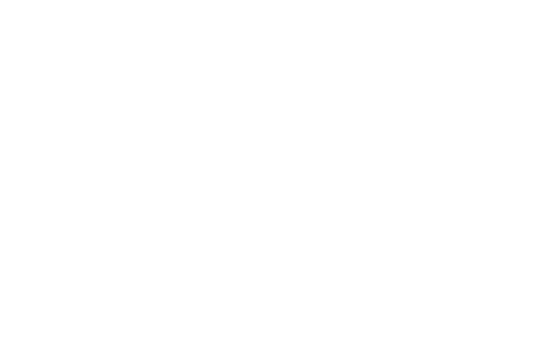

[]

<IPython.core.display.Javascript object>


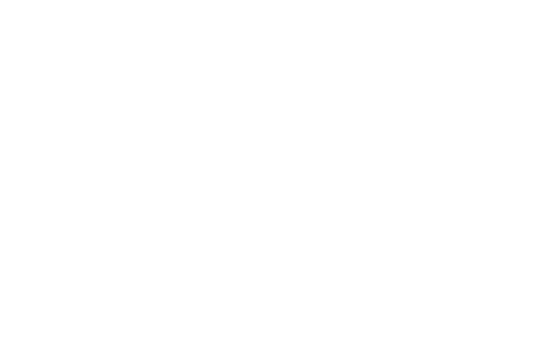

In [48]:
%matplotlib notebook

# Creem figura 3d
from mpl_toolkits.mplot3d import axes3d, Axes3D
# generem dades 3D d'exemple

x_val = [i/100 for i in range(100)]
x_val = np.array(x_val)
y_val = np.exp(x_val)

indices = np.arange(100)
np.random.shuffle(indices)

y_val = y_val[indices]

regr = Regressor( x = x_val, y = y_val)

predX3D = []
for i in x_val:
    predX3D.append(regr.predict(i))

# Afegim els 1's
w = regr.w
print(w)


# Cal desnormalitzar les dades
def desnormalitzar(x, mean, std):
    return x * std + mean

#ara creem la superficies que es un pla

#Dibuixem punts i superficie
# plt.figure()

plt.scatter(x_val, y_val)
plt.scatter(x_val, predX3D)
plt.plot()

[1.4747293249742852, -0.012490705107333964, -0.01103116283970651]


<IPython.core.display.Javascript object>


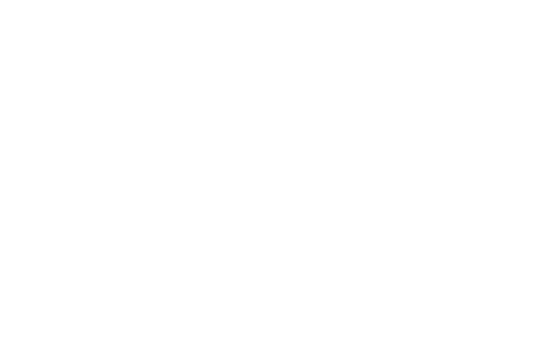

<IPython.core.display.Javascript object>


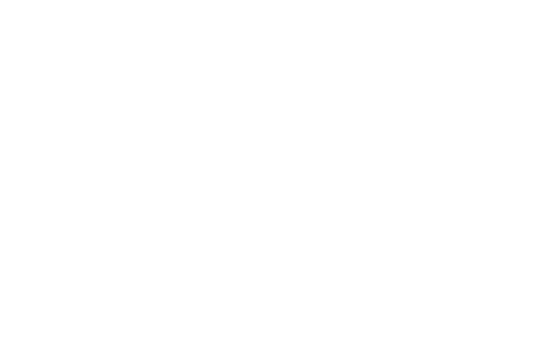

In [49]:
###### %matplotlib notebook

# Creem figura 3d
from mpl_toolkits.mplot3d import axes3d, Axes3D
# generem dades 3D d'exemple

x_val = [i/100 for i in range(100)]
y_val = [i/100 for i in range(100)]
z_val = [i/100 for i in range(100)]

x_val = np.array(x_val)
y_val = np.array(y_val)
z_val = np.exp(z_val)

indices = np.arange(100)
np.random.shuffle(indices)
z_val = z_val[indices]

indices = np.arange(100)
np.random.shuffle(indices)
y_val = y_val[indices]

indices = np.arange(100)
np.random.shuffle(indices)
x_val = x_val[indices]

X = []
for i,j in zip(x_val, y_val):
    X.append(np.array([i, j]))
X = np.array(X)


regr = Regressor( x = X, y = z_val)

predX3D = []
for i in X:
    predX3D.append(regr.predict(i))

# Afegim els 1's
w = regr.w
print(w)


# Cal desnormalitzar les dades
def desnormalitzar(x, mean, std):
    return x * std + mean


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_val, y_val, z_val, c = 'r')
ax.scatter(x_val, y_val, predX3D, c = 'b')
plt.show()

In [50]:
class Regressor(object):
    def __init__(self, x, y, w = [], alpha = 0.1, lam = 0.1, max_iter = 1000, epsilon = 1e-6):
        # Inicialitzem w0 i w1 (per ser ampliat amb altres w's)
        assert len(x) == len(y)
        
        if len(w) == 0:
            try:
                w = [0 for i in range(len(x[0])+1)]
            except:
                w = [0,0]
        
        self.w = w
        self.alpha = alpha
        self.lam = lam
        
        self.train(max_iter, epsilon, x, y)

        
    def predict(self, x):
        # implementar aqui la funció de prediccio
        res = self.w[0]
        try:
            for i,j in zip(x,self.w[1:]):
                res += i*j
        except:
            res +=self.w[1]*np.exp(x)
            
        return res
    
    def __update(self, hy, y, x):
        # actualitzar aqui els pesos donada la prediccio (hy) i la y real.
        for j in range(len(self.w)-1):
            sumatori = 0
            try:
                for i in range(len(hy)):
                    sumatori += (hy[i]-y[i])*x[i]
                self.w[j+1] = self.w[j+1]*(1-self.alpha*self.lam*(1/len(x))) - self.alpha*self.lam*(1/len(x)) * sumatori
            except:
                #print(hy,y,x)
                sumatori = (hy-y)*x
                self.w[j+1] = self.w[j+1]*(1-self.alpha*self.lam)-self.alpha*self.lam*sumatori
                #print(self.w[j], 1-self.alpha*self.lam, self.alpha*self.lam*sumatori)
                self.w[0] -= self.alpha*(hy-y)
                
            
            
    def train(self, max_iter, epsilon, x, y):
        # Entrenar durant max_iter iteracions o fins que la millora sigui inferior a epsilon
        aux = 0
        for k in range(max_iter):
            for i in range(len(x)):
                hy = []
                try:
                    hy = self.predict(x[i])[0]
                    self.__update(hy, y[i], x[i])
                except:
                    hy = self.predict(x[i])
                    self.__update(hy, y[i], x[i])
                MSE = mse([hy],[y[i]])
                #print(MSE, aux)
                #if abs(MSE-aux) < epsilon:
                #    break
                aux = MSE
        try:
            l = len(self.w[1])
            for i in range(1,l+1):
                self.w[i] = self.w[i][i-1]
        except:
            pass
            
                    
            #print(w)
    
import math

def mse(y1, y2):
    # comprovem que y1 i y2 tenen la mateixa mida
    assert(len(y1) == len(y2))
    mse = 0
    for i in range(len(y1)):
        mse += (y1[i] - y2[i])**2
    return mse / len(y1)
            

[1.8477117049453309, -0.0052722435144686415, -0.006678774797318612]


<IPython.core.display.Javascript object>


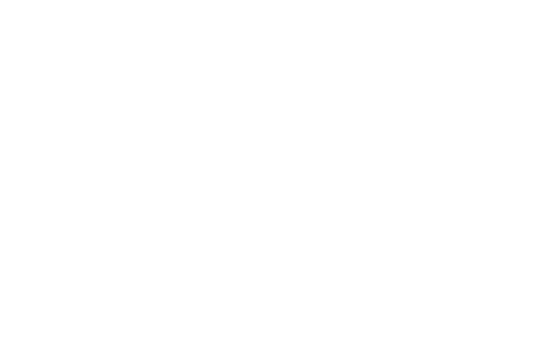

<IPython.core.display.Javascript object>


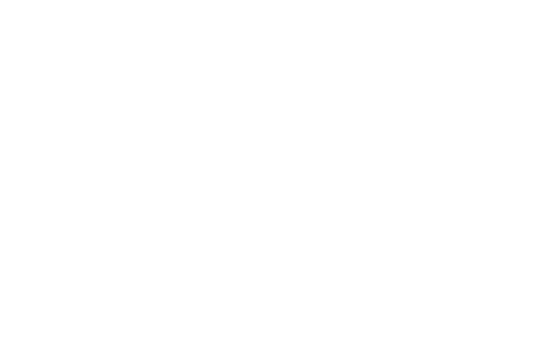

In [52]:
###### %matplotlib notebook

# Creem figura 3d
from mpl_toolkits.mplot3d import axes3d, Axes3D
# generem dades 3D d'exemple

x_val = [i/100 for i in range(100)]
y_val = [i/100 for i in range(100)]
z_val = [i/100 for i in range(100)]

x_val = np.array(x_val)
y_val = np.array(y_val)
z_val = np.exp(z_val)

indices = np.arange(100)
np.random.shuffle(indices)
z_val = z_val[indices]

indices = np.arange(100)
np.random.shuffle(indices)
y_val = y_val[indices]

indices = np.arange(100)
np.random.shuffle(indices)
x_val = x_val[indices]

X = []
for i,j in zip(x_val, y_val):
    X.append(np.array([i, j]))
X = np.array(X)


regr = Regressor( x = X, y = z_val)

predX3D = []
for i in X:
    predX3D.append(regr.predict(i))

# Afegim els 1's
w = regr.w
print(w)


# Cal desnormalitzar les dades
def desnormalitzar(x, mean, std):
    return x * std + mean


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_val, y_val, z_val, c = 'r')
ax.scatter(x_val, y_val, predX3D, c = 'b')
plt.show()